In [ ]:
!pip install catboost lightgbm xgboost --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [ ]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib
from sklearn.metrics import confusion_matrix, roc_curve, auc
from datetime import datetime

# Thiết lập đẹp
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style("whitegrid")

# Tạo thư mục lưu hình
VIS_DIR = "visualizations_colab_final"
os.makedirs(VIS_DIR, exist_ok=True)
print(f"Thư mục lưu hình: {VIS_DIR}")

Thư mục lưu hình: visualizations_colab_final


In [ ]:
# 1. ĐỌC FILE test_features.csv
df = pd.read_csv("/content/drive/MyDrive/eeg_p300_s5_equal_s6_multimodel_save_data/data_csv/test/test_features.csv")
print(f"Đã đọc file: {df.shape[0]} mẫu × {df.shape[1]} cột")

# Tự động phát hiện cột label
if 'label' in df.columns:
    label_col = 'label'
elif 'y' in df.columns:
    label_col = 'y'
elif 'target' in df.columns:
    label_col = 'target'
else:
    raise ValueError("Không tìm thấy cột label!")

df['class'] = df[label_col].map({
    'S  5': 'Standard (S5)', 'S  6': 'Target (S6)',
    0: 'Standard (S5)', 1: 'Target (S6)',
    'S5': 'Standard (S5)', 'S6': 'Target (S6)'
}).fillna("Unknown")
df['y'] = (df['class'] == 'Target (S6)').astype(int)

print("Phân bố lớp:")
print(df['class'].value_counts())

features = [col for col in df.columns if col.startswith('f')]
print(f"Số features: {len(features)}")

Đã đọc file: 584 mẫu × 1399 cột
Phân bố lớp:
class
Standard (S5)    292
Target (S6)      292
Name: count, dtype: int64
Số features: 1397


/tmp/ipython-input-1237422319.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=feat, data=df, palette="Set2")
/tmp/ipython-input-1237422319.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=feat, data=df, palette="Set2")
/tmp/ipython-input-1237422319.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y=feat, data=df, palette="Set2")
/tmp/ipython-input-1237422319.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `

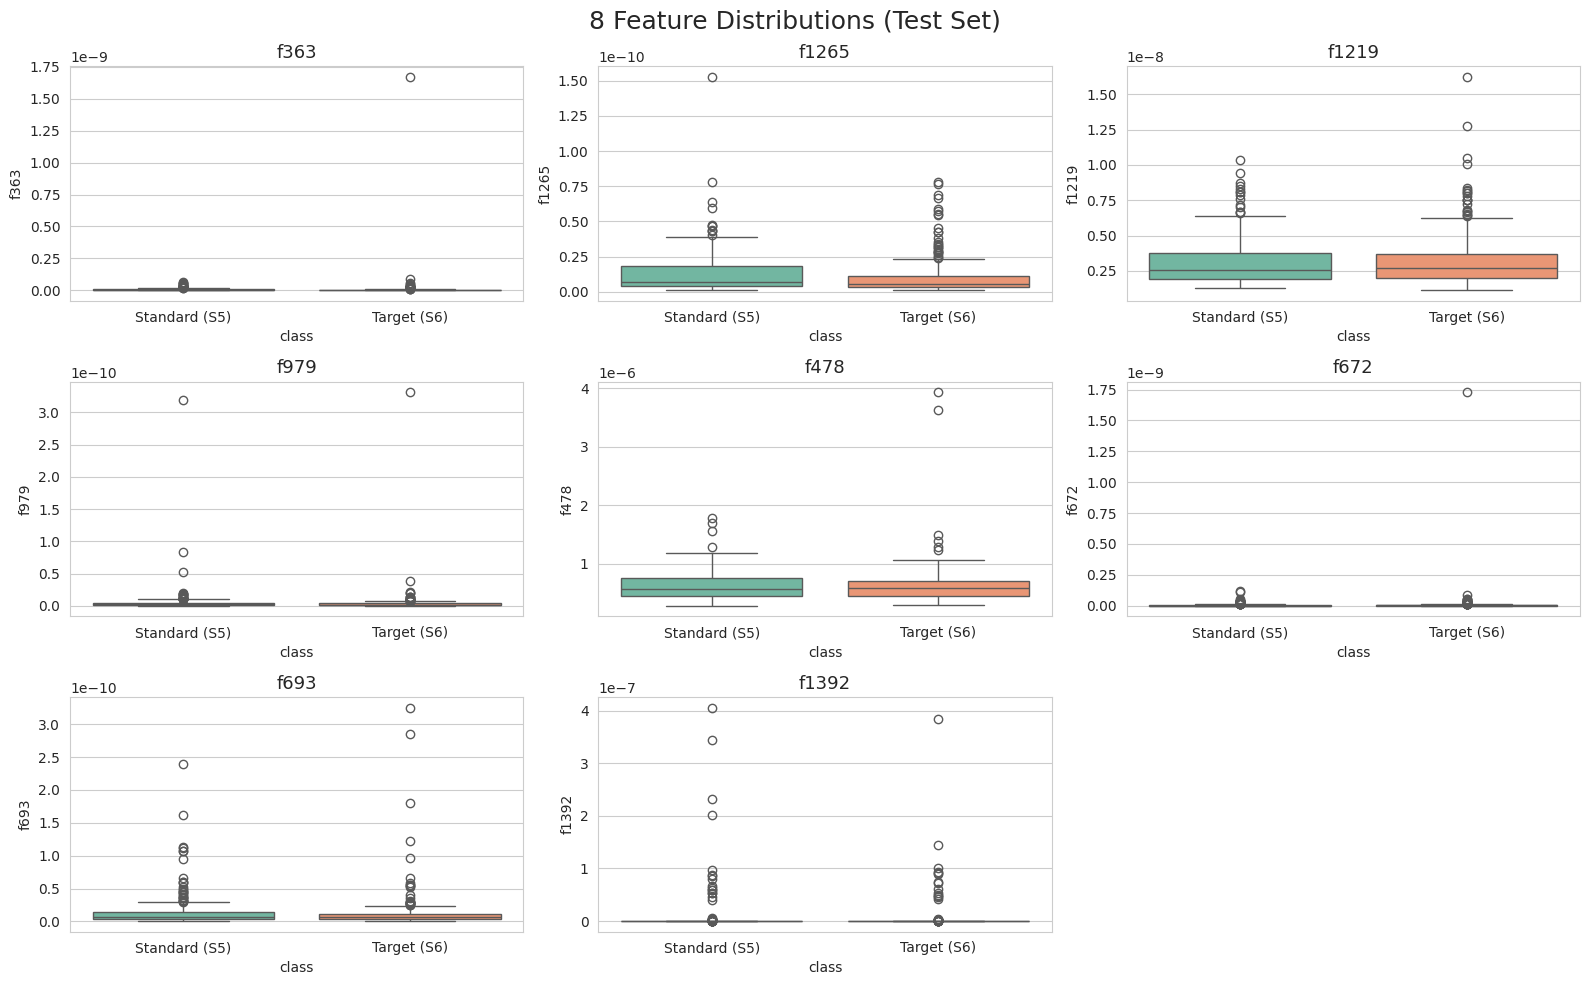

In [ ]:
# 2. VẼ 8 BOXPLOTS ĐẸP
np.random.seed(42)
selected = np.random.choice(features, 8, replace=False)
plt.figure(figsize=(16,10))
for i, feat in enumerate(selected, 1):
    plt.subplot(3,3,i)
    sns.boxplot(x='class', y=feat, data=df, palette="Set2")
    plt.title(feat, fontsize=13)
plt.suptitle('8 Feature Distributions (Test Set)', fontsize=18, y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(VIS_DIR, "01_boxplots.png"), dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# 3. LOAD MODEL CATBOOST
MODEL_DIR = "/content/drive/MyDrive/eeg_p300_s5_equal_s6_multimodel_save_data/models"
model_name = "Cat_Balanced_S5eqS6_20251117_205616.pkl"

best_model_path = os.path.join(MODEL_DIR, model_name)
scaler_path = best_model_path.replace(".pkl", "_scaler.pkl")

print(f"Đang load model: {model_name}")
model = joblib.load(best_model_path)
scaler = joblib.load(scaler_path)
print("Load model + scaler thành công!")

# Dự đoán
X = df[features].values
X_scaled = scaler.transform(X)
y_true = df['y'].values
y_pred = model.predict(X_scaled)
y_prob = model.predict_proba(X_scaled)[:, 1]

acc = np.mean(y_pred == y_true)
print(f"Accuracy trên test set: {acc:.4f} ({acc*100:.2f}%)")

Đang load model: Cat_Balanced_S5eqS6_20251117_205616.pkl
Load model + scaler thành công!
Accuracy trên test set: 0.7055 (70.55%)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


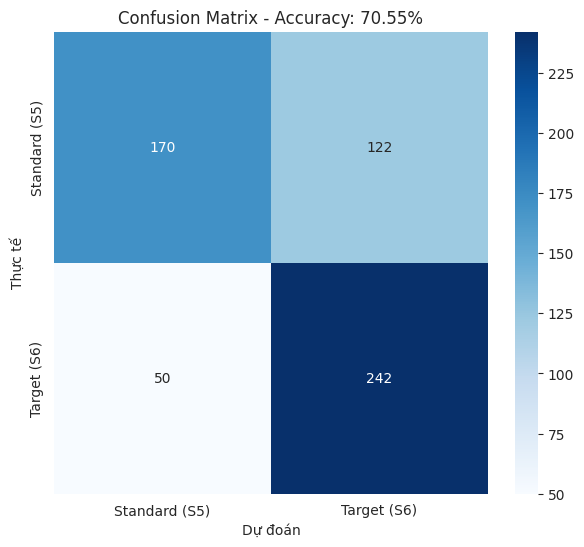

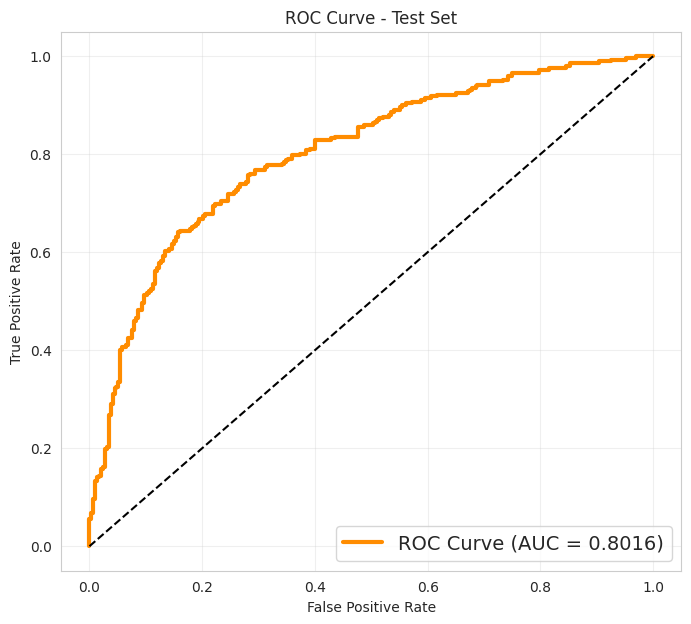

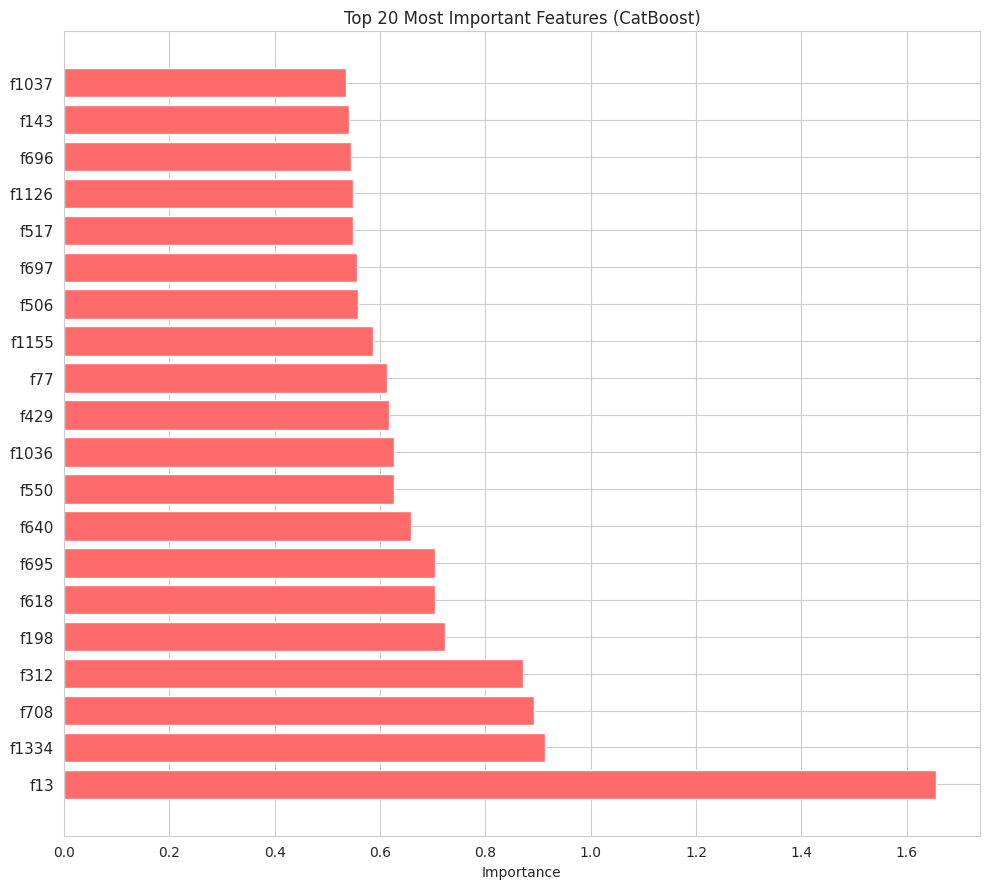

In [ ]:
# 4. VẼ KẾT QUẢ
# 4.1 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Standard (S5)', 'Target (S6)'],
            yticklabels=['Standard (S5)', 'Target (S6)'])
plt.xlabel('Dự đoán'); plt.ylabel('Thực tế')
plt.title(f'Confusion Matrix - Accuracy: {acc*100:.2f}%')
plt.savefig(os.path.join(VIS_DIR, "02_confusion_matrix.png"), dpi=300, bbox_inches='tight')
plt.show()

# 4.2 ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', lw=3, color='darkorange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right", fontsize=14)
plt.grid(alpha=0.3)
plt.savefig(os.path.join(VIS_DIR, "03_roc_curve.png"), dpi=300, bbox_inches='tight')
plt.show()

# 4.3 Feature Importance (CatBoost)
importances = model.get_feature_importance()
top_idx = np.argsort(importances)[-20:][::-1]
top_feats = [features[i] for i in top_idx]

plt.figure(figsize=(10,9))
plt.barh(range(20), importances[top_idx][::-1], color='#FF6B6B')
plt.yticks(range(20), [top_feats[i] for i in range(19,-1,-1)], fontsize=11)
plt.xlabel('Importance')
plt.title('Top 20 Most Important Features (CatBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(os.path.join(VIS_DIR, "04_feature_importance.png"), dpi=300, bbox_inches='tight')
plt.show()

In [8]:
from sklearn.metrics import (
    classification_report, f1_score, recall_score,
    precision_score, accuracy_score, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime

In [9]:
# ------------------- TÍNH TOÁN TẤT CẢ METRIC -------------------
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

accuracy    = accuracy_score(y_true, y_pred)
precision   = precision_score(y_true, y_pred)
recall      = recall_score(y_true, y_pred)        # Sensitivity
specificity = tn / (tn + fp)
f1          = f1_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc     = auc(fpr, tpr)
prec_pr, rec_pr, _ = precision_recall_curve(y_true, y_prob)
pr_auc      = average_precision_score(y_true, y_prob)

# In bảng
print("="*60)
print(f"           ĐÁNH GIÁ CHI TIẾT MODEL (Test Set)")
print("="*60)
print(f"Accuracy        : {accuracy:.4f} ({accuracy*100:6.2f}%)")
print(f"Precision       : {precision:.4f} ({precision*100:6.2f}%)")
print(f"Recall (Sensitivity)  : {recall:.4f} ({recall*100:6.2f}%)")
print(f"Specificity     : {specificity:.4f} ({specificity*100:6.2f}%)")
print(f"F1-Score        : {f1:.4f} ({f1*100:6.2f}%)")
print(f"AUC (ROC)       : {roc_auc:.4f}")
print(f"AUC (PR)        : {pr_auc:.4f}")
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
print("="*60)

           ĐÁNH GIÁ CHI TIẾT MODEL (Test Set)
Accuracy        : 0.7055 ( 70.55%)
Precision       : 0.6648 ( 66.48%)
Recall (Sensitivity)  : 0.8288 ( 82.88%)
Specificity     : 0.5822 ( 58.22%)
F1-Score        : 0.7378 ( 73.78%)
AUC (ROC)       : 0.8016
AUC (PR)        : 0.8004
TP=242, FP=122, TN=170, FN=50


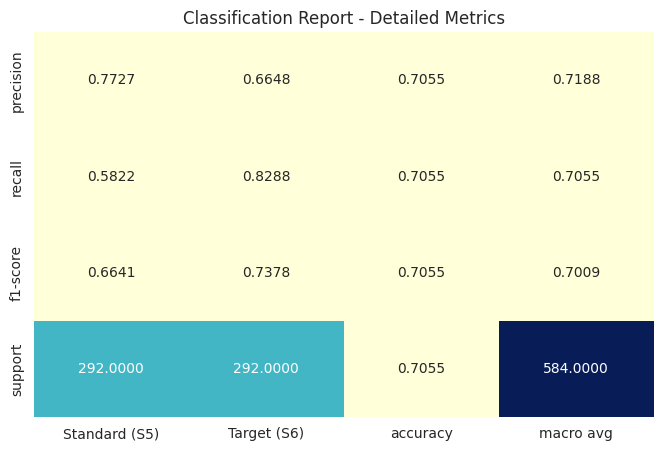

In [10]:
# ------------------- 1. Classification Report dạng bảng đẹp -------------------
report = classification_report(y_true, y_pred, target_names=['Standard (S5)', 'Target (S6)'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df = report_df.round(4)

plt.figure(figsize=(8,5))
sns.heatmap(report_df.iloc[:-1, :].T, annot=True, cmap="YlGnBu", fmt='.4f', cbar=False)
plt.title("Classification Report - Detailed Metrics")
plt.savefig(os.path.join(VIS_DIR, "05_classification_report.png"), dpi=300, bbox_inches='tight')
plt.show()

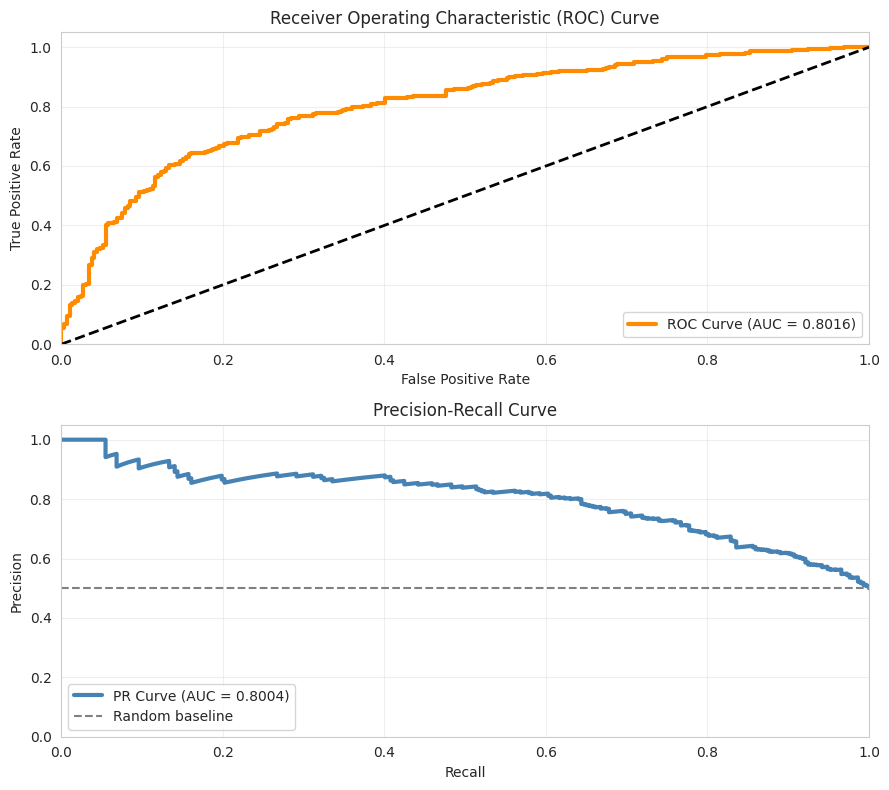

In [11]:
# ------------------- 2. ROC + PR Curve trên cùng 1 hình (rất pro!) -------------------
plt.figure(figsize=(9,8))

# ROC Curve
plt.subplot(2,1,1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})', color='darkorange', lw=3)
plt.plot([0,1],[0,1],'k--', lw=2)
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

# PR Curve
plt.subplot(2,1,2)
plt.plot(rec_pr, prec_pr, label=f'PR Curve (AUC = {pr_auc:.4f})', color='steelblue', lw=3)
plt.axhline(y=sum(y_true)/len(y_true), color='gray', linestyle='--', label='Random baseline')
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(VIS_DIR, "06_roc_pr_curves.png"), dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# ------------------- 3. Bảng tổng hợp metric (dễ copy vào Word/PPT) -------------------
summary = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-Score', 'AUC-ROC', 'AUC-PR'],
    'Value': [accuracy, precision, recall, specificity, f1, roc_auc, pr_auc]
})
summary['Value (%)'] = summary['Value'].apply(lambda x: f"{x*100:.2f}%" if x <= 1 else x)
summary = summary[['Metric', 'Value', 'Value (%)']]

print("\nBảng tóm tắt:")
print(summary.to_string(index=False))

# Lưu bảng ra file CSV (dễ chèn Word)
summary.to_csv(os.path.join(VIS_DIR, "07_evaluation_summary.csv"), index=False)


Bảng tóm tắt:
     Metric    Value Value (%)
   Accuracy 0.705479    70.55%
  Precision 0.664835    66.48%
     Recall 0.828767    82.88%
Specificity 0.582192    58.22%
   F1-Score 0.737805    73.78%
    AUC-ROC 0.801581    80.16%
     AUC-PR 0.800378    80.04%


In [14]:
from google.colab import files
import shutil
shutil.make_archive("visualizations_colab_final", 'zip', VIS_DIR)
files.download("visualizations_colab_final.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>